In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import sys
!pip install torchaudio comet-ml==3.0.2 torchvision==0.6.0

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
import torchaudio
import librosa
import pandas as pd
import numpy as np
import time
import os
from tqdm.notebook import tqdm
import copy

In [5]:
path_to_data = "/content/gdrive/My Drive/Research/savee_png"

In [24]:
data_transform_augmentations = transforms.Compose([
            transforms.Resize((224, 224)), # Вообще в официальном туториале говорится, что надо минимум 224 размер, но я оставил как у нас было и вроде работает
            transforms.RandomApply([
                transforms.RandomResizedCrop((224,224)),
            ],0.6),     
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])

data_transform = transforms.Compose([
            transforms.Resize((224, 224)), # Вообще в официальном туториале говорится, что надо минимум 224 размер, но я оставил как у нас было и вроде работает
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])

tranforms = {'augmentation' : data_transform_augmentations, 'original' : data_transform}

In [42]:
dataset = datasets.ImageFolder(root=path_to_data,
                              transform=tranforms['augmentation'])

In [8]:
dataset.class_to_idx

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'happiness': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

In [38]:
n = len(dataset.samples)
dataset_sizes = {'train' : int(n*0.75), 'val' : int(n*0.25)}
train_set, val_set = torch.utils.data.random_split(dataset, [dataset_sizes['train'], dataset_sizes['val']])
loader_train = torch.utils.data.DataLoader(train_set,
                                              batch_size=16, shuffle=True,
                                              num_workers=4)
loader_val = torch.utils.data.DataLoader(val_set,
                                              batch_size=16, shuffle=True,
                                              num_workers=4)
dataloaders = {'train' : loader_train, 'val' : loader_val}

In [39]:
def train_model(model, criterion, optimizer, scheduler, path_model, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).to(device)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            train_state[phase + '_acc'].append(epoch_acc)
            train_state[phase + '_loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_model_path = path_model + 'best_model_' + str(round(best_acc.item(), 3)) + '.pth' 

                torch.save(best_model_wts, best_model_path)
        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model, best_acc

In [44]:
model = models.resnet18(pretrained=True)
num_classes = len(dataset.class_to_idx)
# replace the last layer (resnet)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# model.classifier = nn.Linear(1024, num_classes) #densenet121
# model.classifier[6] = nn.Linear(4096,num_classes) #alexnet
# model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1)) #squeezenet1_0

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [45]:
train_state = {'train_loss' : [], 'train_acc' : [], 'val_loss' : [], 'val_acc' : []}
if torch.cuda.is_available():
    model.cuda()
model_name = 'best_model_0.633.pth'
best_mod_path = '/content/gdrive/My Drive/Research/SAVEE_experiments/weights/'
#model.load_state_dict(torch.load(best_mod_path + model_name, map_location=device))
model_ret, best_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, best_mod_path, num_epochs=30)
# save model
best_model_path = best_mod_path + 'res_net_model_full_' + str(round(best_acc.item(), 3)) + '.pth'
if best_acc.item() > 0.6:
    torch.save(model_ret.state_dict(), best_model_path)

Epoch 0/29
----------
Iterating through data...
train Loss: 1.6130 Acc: 0.4111
Iterating through data...
val Loss: 3.0617 Acc: 0.4333

Epoch 1/29
----------
Iterating through data...
train Loss: 0.6087 Acc: 0.7778
Iterating through data...
val Loss: 1.3046 Acc: 0.5667

Epoch 2/29
----------
Iterating through data...
train Loss: 0.2836 Acc: 0.9222
Iterating through data...
val Loss: 1.1358 Acc: 0.5667

Epoch 3/29
----------
Iterating through data...
train Loss: 0.2273 Acc: 0.9556
Iterating through data...
val Loss: 1.0855 Acc: 0.6000

Epoch 4/29
----------
Iterating through data...
train Loss: 0.3324 Acc: 0.9111
Iterating through data...
val Loss: 1.0383 Acc: 0.5667

Epoch 5/29
----------
Iterating through data...
train Loss: 0.2574 Acc: 0.9556
Iterating through data...
val Loss: 0.9772 Acc: 0.6333

Epoch 6/29
----------
Iterating through data...
train Loss: 0.2135 Acc: 0.9889
Iterating through data...
val Loss: 0.9227 Acc: 0.6333

Epoch 7/29
----------
Iterating through data...
train L

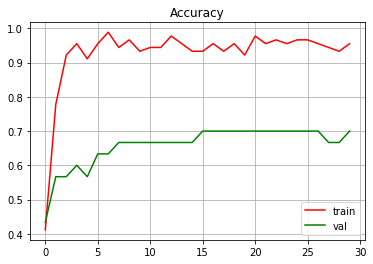

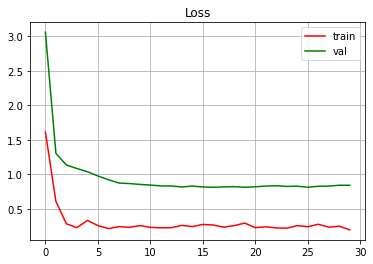

In [46]:
from matplotlib import pyplot as plt
def draw(train_state):
    plt.title('Accuracy')
    train_acc = plt.plot(train_state['train_acc'], 'r-', label='train')
    val_acc = plt.plot(train_state['val_acc'], 'g-', label='val')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.title('Loss')
    train_loss = plt.plot(train_state['train_loss'], 'r-', label='train')
    val_loss = plt.plot(train_state['val_loss'], 'g-', label='val')
    plt.legend()
    plt.grid(True)
    plt.show()

draw(train_state)

In [ ]:
# load model
best_model = models.resnet18(pretrained=True)
# replace the last layer
num_features = model.fc.in_features
best_model.fc = nn.Linear(num_features, 11)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

In [ ]:
# helper function
from PIL import Image
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
data_dir = '/content/gdrive/My Drive/Research/truncted_dataset/'
classes = os.listdir(data_dir)
classes

['yes',
 'up',
 'go',
 'on',
 'off',
 'left',
 'right',
 'down',
 'unknown',
 'no',
 '_background_noise_']